# Differentially private convolutional neural network on MNIST.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/main/examples/differentially_private_sgd.ipynb)

A large portion of this code is forked from the differentially private SGD
example in the [JAX repo](
https://github.com/google/jax/blob/main/examples/differentially_private_sgd.py).

[Differentially Private Stochastic Gradient Descent](https://arxiv.org/abs/1607.00133) requires clipping the per-example parameter
gradients, which is non-trivial to implement efficiently for convolutional
neural networks.  The JAX XLA compiler shines in this setting by optimizing the
minibatch-vectorized computation for convolutional architectures. Train time
takes a few seconds per epoch on a commodity GPU.

In [32]:
import warnings
import dp_accounting
import jax
import jax.numpy as jnp
from optax import contrib
from optax import losses
import optax
from jax.example_libraries import stax
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Shows on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


This table contains hyperparameters and the corresponding expected test accuracy.

| DPSGD      | LEARNING_RATE | NOISE_MULTIPLIER | L2_NORM_CLIP | BATCH_SIZE | NUM_EPOCHS | DELTA | FINAL TEST ACCURACY |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| False      | 0.1       |     NA   |  NA | 256 | 20 | NA | ~99% |
| True   | 0.25        | 1.3        | 1.5 | 256 | 15 | 1e-5 | ~95%|
| True   | 0.15        | 1.1       | 1.0 | 256 | 60 | 1e-5 | ~96.6%|
| True   | 0.25       | 0.7     | 1.5| 256 | 45 | 1e-5 | ~97%|

In [33]:
# @markdown Whether to use DP-SGD or vanilla SGD:
DPSGD = False  # @param{type:"boolean"}
# @markdown Learning rate for the optimizer:
LEARNING_RATE = 0.1  # @param{type:"number"}
# @markdown Noise multiplier for DP-SGD optimizer:
NOISE_MULTIPLIER = 1.1  # @param{type:"number"}
# @markdown L2 norm clip:
L2_NORM_CLIP = 1.0  # @param{type:"number"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 256  # @param{type:"integer"}
# @markdown Number of epochs:
NUM_EPOCHS = 20  # @param{type:"integer"}
# @markdown Probability of information leakage:
DELTA = 1e-5  # @param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

In [34]:
(train_loader, test_loader), info = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True, with_info=True
)

min_max_rgb = lambda image, label: (tf.cast(image, tf.float32) / 255., label)
train_loader = train_loader.map(min_max_rgb)
test_loader = test_loader.map(min_max_rgb)

train_loader_batched = train_loader.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

NUM_EXAMPLES = info.splits["test"].num_examples
test_batch = next(test_loader.batch(NUM_EXAMPLES, drop_remainder=True).as_numpy_iterator())

In [35]:
init_random_params, predict = stax.serial(
    stax.Conv(16, (8, 8), padding="SAME", strides=(2, 2)),
    stax.Relu,
    stax.MaxPool((2, 2), (1, 1)),
    stax.Conv(32, (4, 4), padding="VALID", strides=(2, 2)),
    stax.Relu,
    stax.MaxPool((2, 2), (1, 1)),
    stax.Flatten,
    stax.Dense(32),
    stax.Relu,
    stax.Dense(10),
)

This function computes the privacy parameter epsilon for the given number of steps and probability of information leakage `DELTA`.

In [36]:
def compute_epsilon(steps):
  if NUM_EXAMPLES * DELTA > 1.:
    warnings.warn("Your delta might be too high.")
  q = BATCH_SIZE / float(NUM_EXAMPLES)
  orders = list(jnp.linspace(1.1, 10.9, 99)) + list(range(11, 64))
  accountant = dp_accounting.rdp.RdpAccountant(orders)
  accountant.compose(dp_accounting.PoissonSampledDpEvent(
      q, dp_accounting.GaussianDpEvent(NOISE_MULTIPLIER)), steps)
  return accountant.get_epsilon(DELTA)

In [37]:
@jax.jit
def loss_fn(params, batch):
  images, labels = batch
  logits = predict(params, images)
  return losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean(), logits


@jax.jit
def test_step(params, batch):
  images, labels = batch
  logits = predict(params, images)
  loss = losses.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
  accuracy = (logits.argmax(1) == labels).mean()
  return loss, accuracy * 100

In [38]:
if DPSGD:
  tx = contrib.dpsgd(
      learning_rate=LEARNING_RATE, l2_norm_clip=L2_NORM_CLIP,
      noise_multiplier=NOISE_MULTIPLIER, seed=1337)
else:
  tx = optax.sgd(learning_rate=LEARNING_RATE)

_, params = init_random_params(jax.random.PRNGKey(1337), (-1, 28, 28, 1))
opt_state = tx.init(params)

In [39]:
@jax.jit
def train_step(params, opt_state, batch):
  grad_fn = jax.grad(loss_fn, has_aux=True)
  if DPSGD:
    # Inserts a dimension in axis 1 to use jax.vmap over the batch.
    batch = jax.tree_util.tree_map(lambda x: x[:, None], batch)
    # Uses jax.vmap across the batch to extract per-example gradients.
    grad_fn = jax.vmap(grad_fn, in_axes=(None, 0))

  grads, _ = grad_fn(params, batch)
  updates, new_opt_state = tx.update(grads, opt_state, params)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_opt_state

In [40]:
accuracy, loss, epsilon = [], [], []

for epoch in range(NUM_EPOCHS):
  for batch in train_loader_batched.as_numpy_iterator():
    params, opt_state = train_step(params, opt_state, batch)

  # Evaluates test accuracy.
  test_loss, test_acc = test_step(params, test_batch)
  accuracy.append(test_acc)
  loss.append(test_loss)

  #
  if DPSGD:
    steps = (1 + epoch) * NUM_EXAMPLES // BATCH_SIZE
    eps = compute_epsilon(steps)
    epsilon.append(eps)

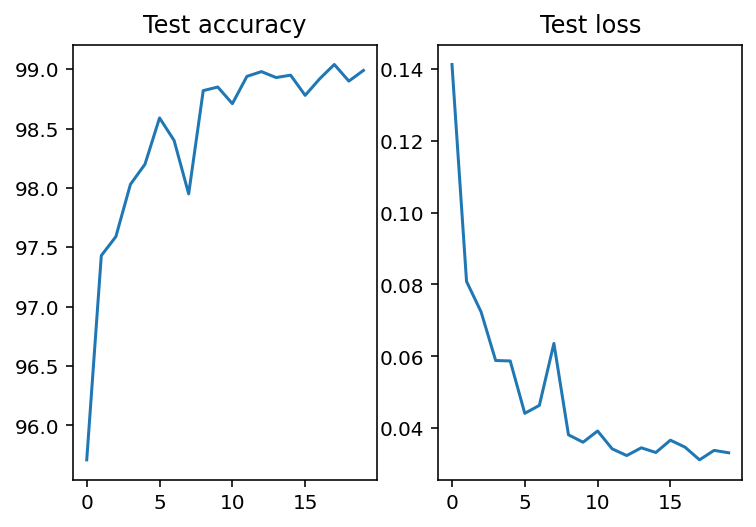

In [41]:
_, axs = plt.subplots(ncols=3 if DPSGD else 2)

axs[0].plot(accuracy)
axs[0].set_title("Test accuracy")
axs[1].plot(loss)
axs[1].set_title("Test loss")

if DPSGD:
  axs[2].plot(epsilon)
  axs[2].set_title("Epsilon")

In [42]:
accuracy[-1]

Array(98.99, dtype=float32)